**遗留问题：**<br>
1. dataset.take()函数是抛出式的提取数据还是查询式提取数据？<br>
2. 计算损失loss时的mask机制是什么，既然mask掉了一部分值，为什么在计算平均损失的时候仍然使用batch中的样本总数而不是总数减去mask掉的那些样本数？<br>
3. 模型训练时不是像预测时那样用前一步的输出作为下一步的输入，而是在decoder端直接采用目标序列的相应词作为输入，这样的不同有什么影响吗？<br>
4. 保存子类API实现的模型时tensorflow存在bug，model.save只能将模型保存为.h5py格式的文件

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据预处理

### 1.1 加载文件，转换字符集编码

之所以要讲unicode编码转换为ascii编码，是因为unicode的词表比较大，运算量相对较大

In [2]:
en_spa_file_path = "./data_spa_en/spa.txt"

import unicodedata
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) # NFD是标准化的一种操作，将多个ascii码组成的unicode拆开
                    if unicodedata.category(c) != "Mn") # Mn是重音格式

en_sentence = "Who lost?"
sp_sentence = "¿Quién perdió?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Who lost?
¿Quien perdio?


### 1.2 对文本进行格式化处理

In [3]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    
    # 标点符号前后加空格
    s = re.sub(r'([?.!,¿])', r" \1 ", s)
    
    # 除了标点符号和字母外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)
    
    # 多余的空格变成一个空格
    s = re.sub(r'[" "]+', " ", s)
    
    # 去掉前后空格
    s = s.rstrip().strip()
    
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> who lost ? <end>
<start> ¿ quien perdio ? <end>


In [4]:
def parse_data(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    sentence_pairs = [line.split("\t") for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


### 1.3 把文本序列转换为数字数列（索引）

In [5]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, 
        filters="", 
        split=" ")
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, 
                                                        padding="post") # 在后面添0用作填充
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])
print(len(input_tokenizer.index_word))
print(len(output_tokenizer.index_word))

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

9402
4833
16 11


### 1.4 切分数据集

In [6]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(
    input_tensor, 
    output_tensor, 
    test_size=0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [7]:
# 验证转换是否正确
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print("%d ---> %s" %(t, tokenizer.index_word[t]))
            
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 ---> <start>
65 ---> he
252 ---> perdido
19 ---> mi
249 ---> llave
3 ---> .
2 ---> <end>

1 ---> <start>
4 ---> i
106 ---> lost
21 ---> my
310 ---> key
3 ---> .
2 ---> <end>


### 1.5 生成dataset数据集

In [8]:
batch_size = 64
epochs = 20
steps_per_epoch = len(input_tensor) // batch_size

In [9]:
def make_dataset(input_tensor, 
                 output_tensor,
                 batch_size, 
                 epochs, 
                 shuffle):
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(
        batch_size, 
        drop_remainder=True) # 当最后一部分数据不足batch_size时舍弃
    return dataset

train_dataset = make_dataset(
    input_train, output_train, batch_size, epochs, True)

eval_dataset = make_dataset(
    input_eval, output_eval, batch_size, 1, False)

In [10]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1    5  506 ...    0    0    0]
 [   1    5   46 ...    0    0    0]
 [   1   33   97 ...    0    0    0]
 ...
 [   1   42 8722 ...    0    0    0]
 [   1   59    8 ...    0    0    0]
 [   1    5  676 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1   22    5   29  363 2726    6    2    0    0    0]
 [   1   51   40   13 1263   33    6    2    0    0    0]
 [   1   28  250  534    3    2    0    0    0    0    0]
 [   1   61   75   63   21  239    3    2    0    0    0]
 [   1    4   23   12 1036   20    3    2    0    0    0]
 [   1    7 3806   46    3    2    0    0    0    0    0]
 [   1   13  560    8   42    3    2    0    0    0    0]
 [   1    7 1373    5    3    2    0    0    0    0    0]
 [   1    4   23  290    3    2    0    0    0    0    0]
 [   1  286   20  194    3    2    0    0    0    0    0]
 [   1   20    8 2092    3    2    0    0    0    0    0]
 [   1    9  853  250 3717    3    2    0    0    0    0]
 [   1

## 2. Encoder Part

In [11]:
embedding_units = 256  # 词向量维度（定义两种语言维度相同）
units = 1024    # 隐藏层单元数（定义encoder和decoder端隐藏节点数相同）
input_vocab_size = len(input_tokenizer.word_index) + 1   # 因为有一个用于表示pad的数字0
output_vocab_size = len(output_tokenizer.word_index) + 1

In [12]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units,
                 batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, 
                                                embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state= True,
                                    recurrent_initializer="glorot_uniform")
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units,
                  units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print("sample_output.shape: ", sample_output.shape)
print("sample_hidden.shape: ", sample_hidden.shape)

sample_output.shape:  (64, 16, 1024)
sample_hidden.shape:  (64, 1024)


## 3. Attention Part

In [13]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        # before V: (batch_size, length, units)
        # after V: (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))

        #shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #context_vector.shape : (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs

        #context_viector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
attention_model = BahdanauAttention(units=10)
attention_results, attention_weights = attention_model(
    sample_hidden, sample_output)

print("attention_results.shape", attention_results.shape)
print("attention_weights.shape", attention_weights.shape)

attention_results.shape (64, 1024)
attention_weights.shape (64, 16, 1)


## 4. Decoder Part

In [14]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units,
                 decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(
            vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer="glorot_uniform")
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(
            hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape: (batch_size, 1, embeding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat(
            [tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # output.shape: [batch_size, 1, decoding_units]
        # state.shape: [batch_size, decoding_units]
        output, state = self.gru(combined_x)
        
        # output.shape: [batch_size, decoding_units]
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape: [batch_size, vocab_size]
        output = self.fc(output)
        
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)),
                  sample_hidden,
                  sample_output)
decoder_output, decoder_hidden, decoder_aw = outputs

print("decoder_output.shape: ", decoder_output.shape)
print("decoder_hidden.shape: ", decoder_hidden.shape)
print("decoder_attention_weights.shape: ", decoder_aw.shape)

decoder_output.shape:  (64, 4834)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape:  (64, 16, 1)


In [15]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction="none")      # 先不进行汇总计算

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## 5. 定义损失函数和优化器

In [16]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(
            inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        for t in range(0, targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
            predictions, decoding_hidden, attention_weight = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions)
            
    batch_loss = loss / int(targ.shape[0])  # 有些被mask掉了，平均数为何不是除以非零的数量和而是总的数量??????????????????????????
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradient = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradient, variables))
    return batch_loss

## 6. 训练模型

In [17]:
train_model = input("Is this a trianing model ? (yes or no)---> ")
if train_model == "yes":
    for epoch in range(1, epochs+1):
        start = time.time()

        encoding_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(
            train_dataset.take(steps_per_epoch), 1):
            batch_loss = train_step(inp, targ, encoding_hidden)
            total_loss += batch_loss

            if batch % 100 == 0:
                print("Epoch {} Batch {} Loss {:.4f}".format(
                    epoch, batch, batch_loss.numpy()))

        print("Epoch {} Loss {:.4f}".format(epoch,
                                            total_loss / steps_per_epoch))
        print("Time take for 1 epoch {} sec\n".format(time.time() - start))

Is this a trianing model ? (yes or no)--->  no


## 7. 预测及结果检验

In [18]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(" ")]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs],
    maxlen=max_length_input,
    padding="post")
    inputs = tf.convert_to_tensor(inputs)
    
    results = ""
#     encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    # decoding_input.shape: (1, 1)
    decoding_input = tf.expand_dims(
        [output_tokenizer.word_index["<start>"]], 0)
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_outputs)
        
        # attention_weights.shape: (batch_size, input_length, 1) (1, 16, 1)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size) (1, 4834)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + " "
        if output_tokenizer.index_word[predicted_id] == "<end>":
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap="viridis")
    
    font_dict = {"fontsize": 14}
    
    ax.set_xticklabels([""] + input_sentence, 
                       fontdict=font_dict, 
                       rotation=90)
    ax.set_yticklabels([""] + predicted_sentence,
                       fontdict=font_dict)
    plt.show()
    
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    print("Input: %s" %(input_sentence))
    print("Predicted translate: %s" %(results))
    
    attention_matrix = attention_matrix[:len(results.split(" ")),
                                        :len(input_sentence.split(" "))]
    plot_attention(attention_matrix, 
                   input_sentence.split(" "),
                   results.split(" "))

Input: <start> tom es mi nombre , tengo anos . <end>
Predicted translate: raised occupied get confirm list computer eventually popular gander computer eventually 


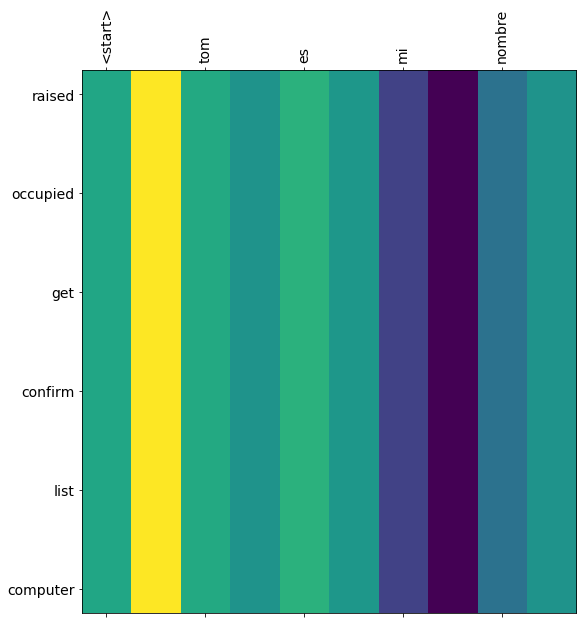

In [19]:
translate(u"Tom es mi nombre, tengo 29 años.")

## 8.保存和提取模型参数

In [20]:
if train_model == "yes":
    encoder_path = "./seq2seq_attention_save_encoder/"
    decoder_path = "./seq2seq_attention_save_decoder/"

    def create_dir(path):
        if not os.path.exists(path):
            os.mkdir(path)

    create_dir(encoder_path)
    create_dir(decoder_path)

    # 查看参数
    def print_param_info(coder):
        for matrix in coder.weights:
            print(matrix.name, matrix.shape)
    print_param_info(encoder)
    print("-------------")
    print_param_info(decoder)

    # 保存参数
    encoder.save_weights(encoder_path)
    decoder.save_weights(decoder_path)

Input: <start> esta es mi familia <end>
Predicted translate: this is my family . <end> 


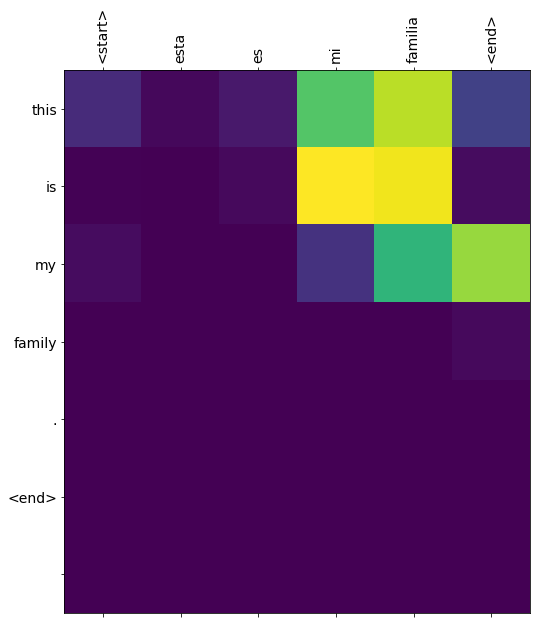

In [35]:
# 加载参数
encoder_path = "./seq2seq_attention_save_encoder/"
decoder_path = "./seq2seq_attention_save_decoder/"
encoder.load_weights(encoder_path)
decoder.load_weights(decoder_path)
translate(u"esta es mi familia")